## Data processing

- load data sets
- correct data
- merge imu and tablet data
- split data into segments
- compute quaternion representation
- compute rotation matrices
- compute navigation frame data
- integrate twice for position data 
- plot


### Imports and load data
----------------------------------------------------------------------------------------------------------

In [21]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import ahrs
from numpy.linalg import norm
import plotly.graph_objects as go

In [2]:
# load data

PATH_TO_DATA = "../data/"
imu = pd.read_csv(PATH_TO_DATA + "set1_imu.csv", encoding="utf-8")
tab = pd.read_csv(PATH_TO_DATA + "set1_tab.csv", encoding="utf-16")

# maybe need to channge the encoding depending on which set

### Correct and merge data and split into segments
----------------------------------------------------------------------------------------------------------

In [3]:
# correct data

ACC_OFFSET = [0.00456531,  0.00791233, -0.02643263]
ACC_SCALE = [0.10216491, 0.10159286, 0.10136561] 

GYRO_OFFSET = [-0.019417  ,  0.05761032,  0.03028953]

FILTER_GAIN = np.sqrt(3/4) * np.mean(GYRO_OFFSET)

#imu[['gx', 'gy', 'gz']] = imu[['gx', 'gy', 'gz']] + GYRO_OFFSET

#imu[['ax', 'ay', 'az']] = imu[['ax', 'ay', 'az']] * ACC_SCALE * 9.81 + ACC_OFFSET



In [4]:
# merge data
# do not need to normalize data, this happens in updateIMU

def merge_data(imu, tab):
    """
    Input: 
        imu: pd.DataFrame with columns [host_timestamp, arduino_timestamp, ax, ay, az, gx, gy, gz, temperature]
        tab: pd.DataFrame with columns [host_timestamp, x, y, z, in_range, touch, pressure, reset]
 
    Output: 
        pd.DataFrame containing imu and tab data with interpolated values for the tab data
    """
    t_left, t_right = tab["host_timestamp"].iloc[[0, -1]]
    i_left, i_right = imu["host_timestamp"].iloc[[0, -1]]
    left = max(t_left, i_left)
    right = min(t_right, i_right)

    # use imu data set as base to merge on
    df = imu[(imu["host_timestamp"] >= left) & (imu["host_timestamp"] <= right)].copy() 

    for column in ["x", "y", "z", "in_range", "touch", "pressure"]:
        df[column] = np.interp(df["host_timestamp"], tab["host_timestamp"], tab[column])

    # For reset, assign to closest timestamp
    mask = tab["reset"] != 0
    indices = np.searchsorted(df["host_timestamp"], tab.loc[mask, "host_timestamp"])
    df["reset"] = 0
    df.loc[df.index[indices], "reset"] = tab.loc[mask, "reset"].values

    return df

In [5]:
def adjust_timestamps(df):
    df['arduino_timestamp'] = df['arduino_timestamp'].apply(lambda x: (x - min(df['arduino_timestamp'])) /1000)
    return df

In [6]:
# split data into segments (individual sentences)

def split_into_segments(df: pd.DataFrame):
    data_segments = {}
    split_indices, = np.where(df["reset"] == 1)
    if split_indices == []:
        return df # no segments reported
    for i in range(len(split_indices)-1):
        data_segments["segment_"+str(i)] = df.iloc[split_indices[i]:split_indices[i+1]]
    return data_segments



### Compute quaternion representation / orientation estimation
----------------------------------------------------------------------------------------------------------

In [7]:
"""
Body Frame matches the frame of the platform the sensors are mounted on. 
The origin coincides with the center of gravity of the platform. 
The Y-axis points forward of the moving platform, while the Z-axis points upwards.
The X-axis completes the right-hand system pointing in traverse direction. 

To obtain the objective function of the gravitational acceleration, we assume, by convention, that the vertical Z-axis is defined by the direction of the gravity Eg=[0001].

Taking the derivative of the sensor's orientation relative to Earth and 
rotating this orientation by the angular rate of change,
we can calculate the updated angular rate of change of the sensor


We know the direction of gravity in the earth frame and we know the direction of gravity in the sensor
frame. This allows us to calculate the orientation of the sensor frame relative to the earth frame. 
Madgwick formulates optimisation problem, since quaternion representation requires complete solution
=> min(q, Earth frame, sensor frame) with q is the transformation va = q vb qt and q can be transformed into 
the rotation matrix E(0,x,y,z) s=(0,x,y,z) q=(q0,q1,q2,q3)


Quaternion Estimation with a IMU architecture.

The estimation is made in two steps: a prediction is done with the angular rate (gyroscope) 
to integrate and estimate the current orientation; then a correction step uses the measured 
accelerometer to infer the expected gravity vector and use it to correct the predicted quaternion.


In the context of an orientation filter, it will intially be assumed that an accelerometer will measure only gravity.
Muss in Ruheposition gestartet werden.
"""


# use Madgwick filter to compute quaternion representation
madgwick = ahrs.filters.Madgwick()


def quat(d): #input dictonary with multiple segments
    for segment in d.keys():
        T = d[segment]["arduino_timestamp"].values
        A = d[segment][["ax", "ay", "az"]].values
        G = d[segment][["gx", "gy", "gz"]].values
        Q = np.zeros((len(T), 4))
        Q[0] = ahrs.common.orientation.acc2q(A[0])
        #Q[0] = np.array([1.0, 0.0, 0.0, 0.0])
        for i in range(1, len(T)):
            madgwick.Dt = (T[i] - T[i - 1]) 
            Q[i] = madgwick.updateIMU(Q[i - 1], G[i], A[i])
        df_q = pd.concat([d[segment].reset_index(drop=True), pd.DataFrame(Q, columns=['q0','q1','q2','q3'])], axis=1)
        d.update({segment:df_q})
         
    return d

def quat_df(df): # input dataframe/single segment
    T = df["arduino_timestamp"].values
    A = df[["ax", "ay", "az"]].values
    G = df[["gx", "gy", "gz"]].values
    Q = np.zeros((len(T), 4))
    Q[0] = ahrs.common.orientation.acc2q(A[0]) # this probably assumes that az is the gravity axis
    #Q[0] = np.array([1.0, 0.0, 0.0, 0.0])
    for i in range(1, len(T)):
        madgwick.Dt = (T[i] - T[i - 1]) 
        Q[i] = madgwick.updateIMU(Q[i - 1], G[i], A[i])
    df_q = pd.concat([df.reset_index(drop=True), pd.DataFrame(Q, columns=['q0','q1','q2','q3'])], axis=1)

    return df_q

### Compute rotation matrices and navigation frame data
----------------------------------------------------------------------------------------------------------

In [8]:
# compute rotation matrix (only for one array of quaternion)
def rotation_matrix(q):
    """
    Input:
        Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output:
        3x3 rotation matrix. 
        This rotation matrix converts a point in the local reference 
        frame to a point in the navigation reference frame.
    """

    # divide by norm so we have a unit quaternion
    q0 = q[0] / norm(q)
    q1 = q[1] / norm(q)
    q2 = q[2] / norm(q)
    q3 = q[3] / norm(q)

    R = np.zeros((3,3))
     
    R[0,0] = 1- 2 * (q2 * q2 + q3 * q3) 
    R[0,1] = 2 * (q1 * q2 - q0 * q3)
    R[0,2] = 2 * (q1 * q3 + q0 * q2)
     
    R[1,0] = 2 * (q1 * q2 + q0 * q3)
    R[1,1] = 1 - 2 * (q1 * q1 + q3 * q3) 
    R[1,2] = 2 * (q2 * q3 - q0 * q1)
     
    R[2,0] = 2 * (q1 * q3 - q0 * q2)
    R[2,1] = 2 * (q2 * q3 + q0 * q1)
    R[2,2] = 1 - 2 * (q1 * q1 + q2 * q2) 

    # inverse of R is body to global, matrix is orthogonal so transpose is equal to inverse                  
    return np.transpose(R)


def rotations_matrices(d):
    for segment in d.keys():
        d[segment]['r'] = d[segment].apply(lambda row: rotation_matrix([row.q0, row.q1, row.q2, row.q3]), axis=1)
    return d

def navigation_acc(R: np.ndarray, acc: list):
    """
    Input:
        R: IMU body frame to global frame rotation matrix
        acc: acceleration in the body frame
    Output: 
        array of acceleration in the global frame
    """
    nav_acc = R @ acc
    return nav_acc[0], nav_acc[1], nav_acc[2] # shape (3,)

def nav_acc(d):
    for segment in d.keys():
        d[segment][['nav_ax', 'nav_ay', 'nav_az']] = d[segment].apply(lambda row: pd.Series(navigation_acc(row.r, [row.ax, row.ay, row.az])), axis=1) 
        # correct for gravity
        d[segment]['az'] = d[segment]['az'].apply(lambda x: x + 9.81) 
    return d



### Integrate data
----------------------------------------------------------------------------------------------------------

In [9]:
def integrate_1d(t, dx, x0=0):
    (n,) = dx.shape
    x = np.zeros_like(dx)
    x[0] = x0
    for i in range(1, n):
        dt = (t[i] - t[i - 1]) 
        x[i] = (dx[i - 1] + dx[i]) / 2 * dt + x[i - 1]
        
    return x

def integrate(df):
    T = df["arduino_timestamp"].values
    vel_x = integrate_1d(T,df['nav_ax'])
    vel_y = integrate_1d(T,df['nav_ay'])
    vel_z = integrate_1d(T,df['nav_az'])

  # use starting point tab as intial integration start
    pos_x = integrate_1d(T,vel_x, df.x[0])
    pos_y = integrate_1d(T,vel_y, df.y[0])
    pos_z = integrate_1d(T,vel_z, df.z[0])

    return vel_x, vel_y,vel_z,pos_x,pos_y,pos_z


### Plot data
----------------------------------------------------------------------------------------------------------

In [10]:
def plot_segment(df, segment):
    touch = df["segment_{}".format(segment)]["touch"] > 0
    plt.plot(df["segment_{}".format(segment)]["x"].where(touch), df["segment_{}".format(segment)]["y"], c='black')
    plt.plot(df["segment_{}".format(segment)]["x"].where(~touch), df["segment_{}".format(segment)]["y"], c='grey', alpha=0.4)
    plt.rcParams["figure.figsize"] = (10,5)
    plt.show()

In [11]:
def plot_segments(df):
    fig, axes = plt.subplots(8, figsize=(8, 16))
    vel_x,vel_y,vel_z,pos_x,pos_y,pos_z = integrate(df)
    
    is_touch = df["touch"] == 1
    axes[0].plot(df["x"].where(is_touch), df["y"].where(is_touch), c="k")
    axes[0].plot(df["x"].where(~is_touch), df["y"].where(~is_touch), c="grey", alpha= 0.4)
    axes[0].set_ylabel('tablet data')

    axes[1].plot(df['arduino_timestamp'], df['ax'], c="k", label= "sensor frame")
    axes[1].plot(df['arduino_timestamp'], df['nav_ax'], c="r", label= "nav frame")
    axes[1].set_ylabel('ax  [m/s^2]')
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[2].plot(df['arduino_timestamp'], df['ay'], c="k", label= "sensor frame")
    axes[2].plot(df['arduino_timestamp'], df['nav_ay'], c="r", label= "nav frame")
    axes[2].set_ylabel('ay  [m/s^2]')
    axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[3].plot(df['arduino_timestamp'], df['az'], c="k", label= "sensor frame")
    axes[3].plot(df['arduino_timestamp'], df['nav_az'], c="r", label= "nav frame")
    axes[3].set_ylabel('az  [m/s^2]')
    axes[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))

    axes[4].plot(df['arduino_timestamp'], vel_x, c="k")
    axes[4].set_ylabel('vel x')
    axes[5].plot(df['arduino_timestamp'], vel_y, c="k")
    axes[5].set_ylabel('vel y')  
    axes[6].plot(df['arduino_timestamp'], vel_z, c="k")
    axes[6].set_ylabel('vel z')
   
    axes[7].plot(pos_x, pos_y, c="k")
    axes[7].set_ylabel('integrated positions')

    fig.align_ylabels()
    fig.tight_layout()

    plt.show()

In [51]:
def plot_3d(df):
    plt.style.use('seaborn')

    vel_x, vel_y,vel_z,pos_x,pos_y,pos_z = integrate(df)

    fig3,ax = plt.subplots()
    fig3.suptitle('3D Trajector',fontsize=20)
    ax = plt.axes(projection='3d')
    ax.plot3D(pos_x,pos_y,pos_z,c='red')
    ax.plot3D(df.x ,df.y, df.z, c='blue' )
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')
    plt.show()

def plot_3d_tab(df):
    plt.style.use('seaborn')

    fig3,ax = plt.subplots()
    fig3.suptitle('3D Trajector',fontsize=20)
    ax = plt.axes(projection='3d')
    ax.plot3D(df.x ,df.y, df.z, c='blue' )
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    ax.set_zlabel('Z position')
    plt.show()

In [158]:
def interactive_3d_plot_positions(df):
    vel_x, vel_y,vel_z,pos_x,pos_y,pos_z = integrate(df)
    fig = go.Figure(data=[go.Scatter3d(mode='markers',x= pos_x, y= pos_y, z = pos_z, marker=dict(size=1))])
    fig.update_layout(
                title= {'text': "Integrated positions", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
                scene = dict(
                    xaxis_title='X AXIS',
                    yaxis_title='Y AXIS',
                    zaxis_title='Z AXIS'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
    fig.show()

def interactive_3d_plot_tab(df):
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(mode='markers',x= df.x, y= df.y, z = df.z, marker=dict(size=1)))
    fig.add_trace(go.Scatter3d(mode='markers',x= [min(df.x)], y= [max(df.y)], z = [0], marker=dict(size=10), name="upper left corner tablet"))
    fig.update_layout(
                title= {'text': "Tablet data", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
                scene = dict(
                    xaxis_title='X AXIS',
                    yaxis_title='Y AXIS',
                    zaxis_title='Z AXIS'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
    fig.show()

def interactive_plot(df):
    vel_x, vel_y,vel_z,pos_x,pos_y,pos_z = integrate(df)
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(mode='markers',x= pos_x, y= pos_y, z = pos_z, marker=dict(size=1), name="calculated positions"))
    fig.add_trace(go.Scatter3d(mode='markers',x= df.x, y= df.y, z = df.z, marker=dict(size=1), name="tablet data"))
    fig.add_trace(go.Scatter3d(mode='markers',x= [min(df.x)], y= [max(df.y)], z = [0], marker=dict(size=10), name="upper left corner tablet"))
    fig.update_layout(
                title= {'text': "Combined", 'y':0.95, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
                scene = dict(
                    xaxis_title='X AXIS',
                    yaxis_title='Y AXIS',
                    zaxis_title='Z AXIS'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
    
    fig.show()




## Examples
----------------------------------------------------------------------------------------------------------

### Example 1 - rectangle drawing

In [185]:
# load data

imu = pd.read_csv(PATH_TO_DATA + "o_imu.csv", encoding="utf-8")
tab = pd.read_csv(PATH_TO_DATA + "o_tab.csv", encoding="utf-16")

In [186]:
imu[['gx', 'gy', 'gz']] = imu[['gx', 'gy', 'gz']] + GYRO_OFFSET
imu[['ax', 'ay', 'az']] = imu[['ax', 'ay', 'az']] * ACC_SCALE  + ACC_OFFSET # it makes sense to divide by 9.81 as done in the calibration because the loss function alignes the vector [0,0,1] in earth frame
df = merge_data(imu, tab)
df = adjust_timestamps(df)
df = df[df['arduino_timestamp'] > 5]
df = df[df['arduino_timestamp'] < 20]
df = quat_df(df)
df['r'] = df.apply(lambda row: rotation_matrix([row.q0, row.q1, row.q2, row.q3]), axis=1) # add rotation matrices as column r
df[['nav_ax', 'nav_ay', 'nav_az']] = df.apply(lambda row: pd.Series(navigation_acc(row.r, [row.ax, row.ay, row.az])), axis=1)
df['nav_az'] = df['nav_az'].apply(lambda x: x - 1)

print(df.head(1))



    host_timestamp  arduino_timestamp        ax        ay        az        gx  \
0  319072947405000              5.004 -0.924144 -0.016277 -0.369038  0.061183   

        gy       gz  temperature           x  ...      pressure  reset  \
0 -0.01809  0.01319        20.18 -119.787339  ...  24142.522782      0   

         q0        q1        q2        q3  \
0  0.018179 -0.827717  0.012796  0.560705   

                                                   r    nav_ax    nav_ay  \
0  [[0.37089142827277766, -0.0007964506018363522,... -0.000027  0.060487   

     nav_az  
0 -0.006603  

[1 rows x 24 columns]


In [187]:
#df['nav_az'] = df['nav_az'].apply(lambda x: x - 9.81) # 1 instead of 9.81
vel_x, vel_y,vel_z,pos_x,pos_y,pos_z = integrate(df)

print(min(pos_x), min(df.x), max(pos_x), max(df.x))

-120.0927636156399 -269.5898374914168 -119.63477433633606 1649.8828107118334


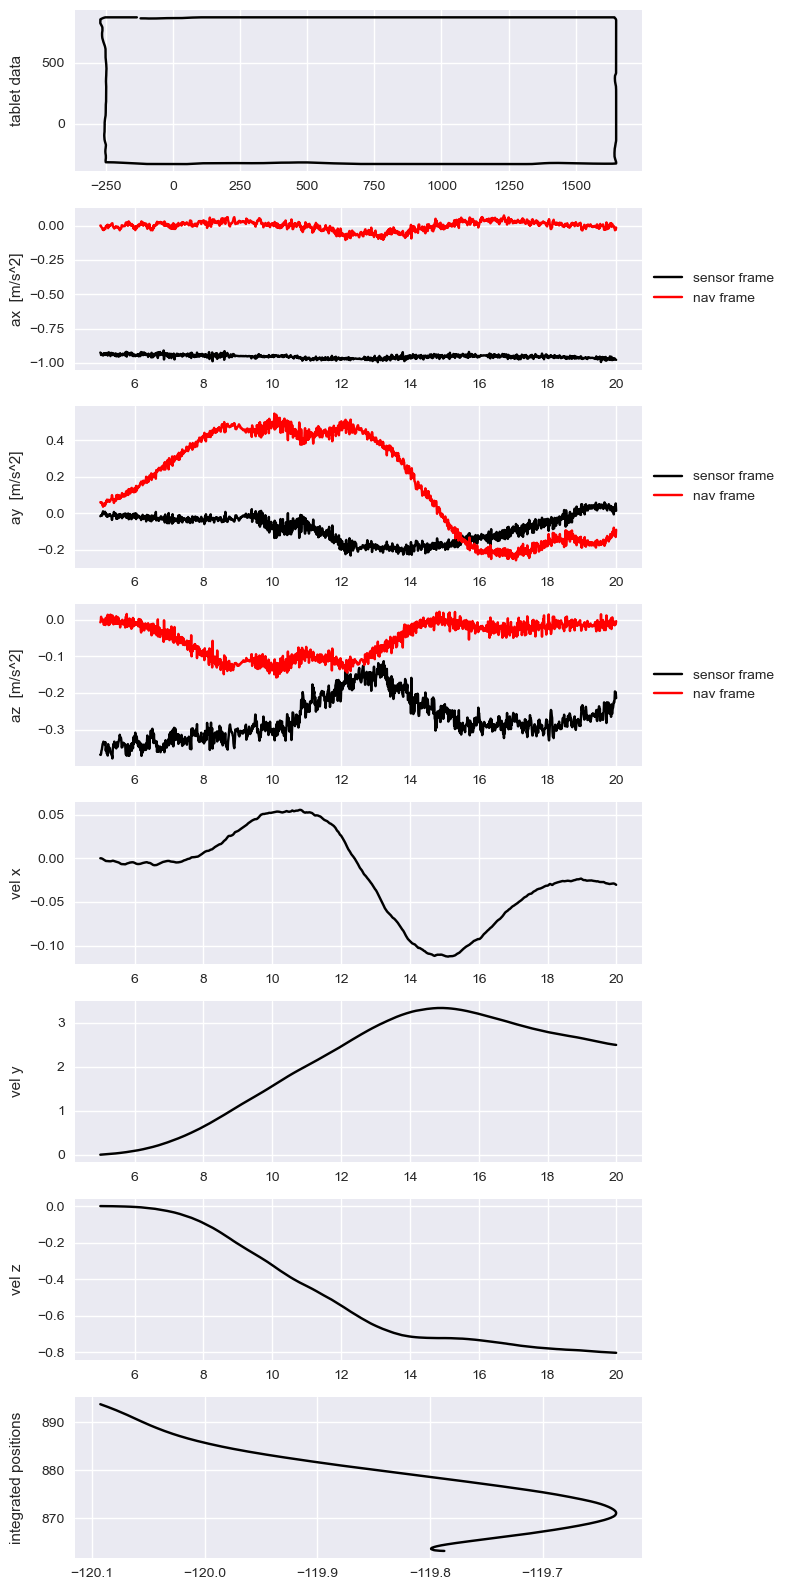

In [188]:
plot_segments(df)

In [189]:
interactive_3d_plot_tab(df)

In [190]:
interactive_3d_plot_positions(df)

In [191]:
interactive_plot(df)

----------------------------------------------------------------
### Example 2 - sentence from first collected data batch

In [169]:
imu = pd.read_csv(PATH_TO_DATA + "set1_imu.csv", encoding="utf-8")
tab = pd.read_csv(PATH_TO_DATA + "set1_tab.csv", encoding="utf-16")
df = merge_data(imu, tab)
d = split_into_segments(df) # becomes dictonary
d = quat(d) # add columns for quaternions, what is starting position and orientation
d = rotations_matrices(d) # add rotation matrices as column r
d = nav_acc(d)
d['segment_10'].head(1)

C:\Users\ann-k\AppData\Local\Temp\ipykernel_9576\2815078254.py:6: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



,host_timestamp,arduino_timestamp,ax,ay,az,gx,gy,gz,temperature,x,...,pressure,reset,q0,q1,q2,q3,r,nav_ax,nav_ay,nav_az
0,43571084048700,929972,-7.3005,4.7438,14.2307,-0.1747,-0.0757,-0.0391,22.04,615.489815,...,0.0,1,0.748886,-0.62582,0.167157,-0.13992,"[[0.9049620954548059, -0.4187880639965216, -0....",-8.92591,-3.510772,1.829246


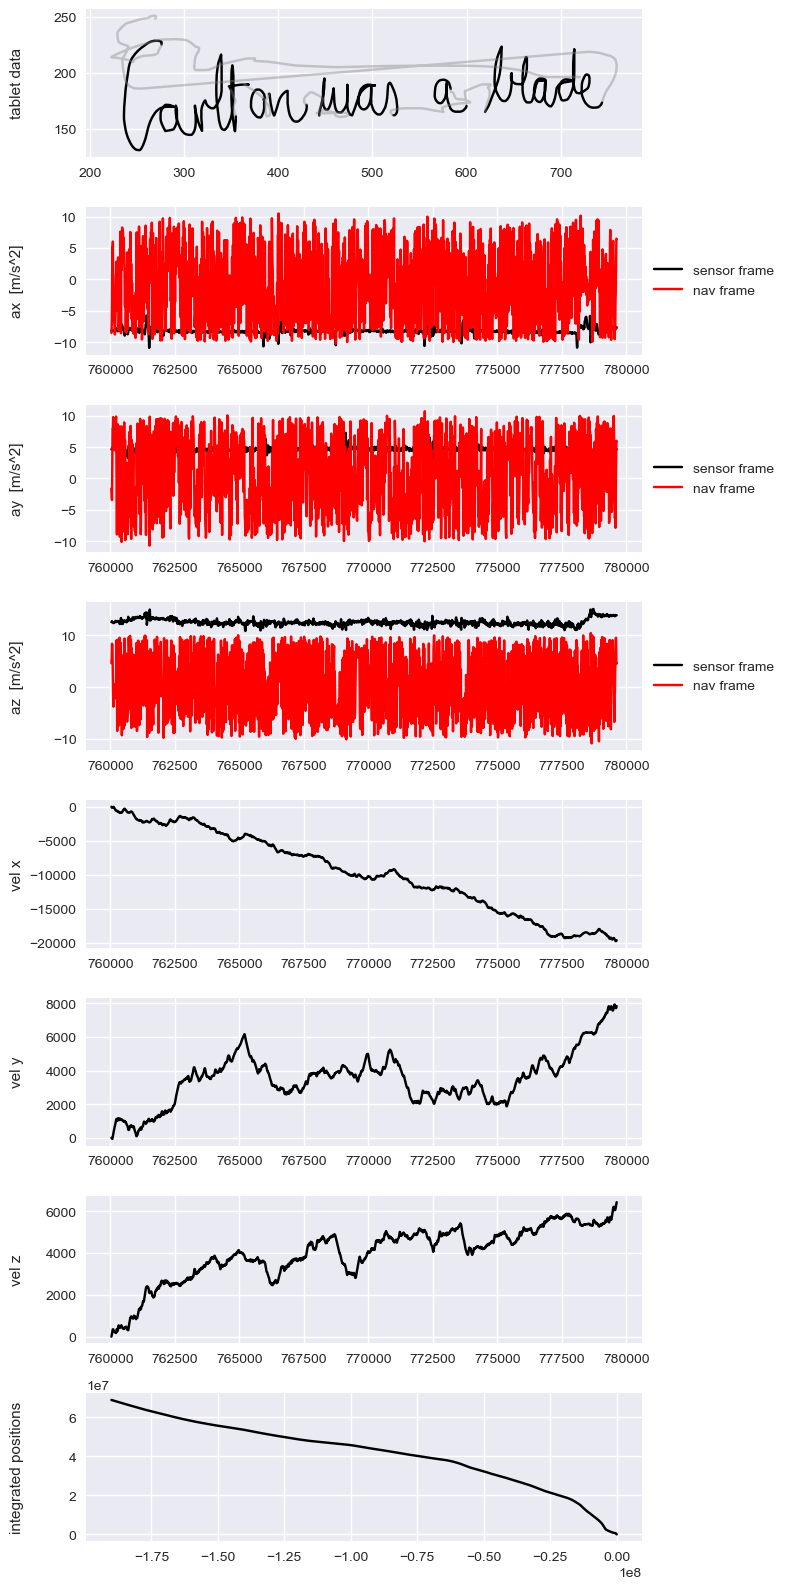

In [170]:
plot_segments(d['segment_1'])

In [161]:
interactive_3d_plot_tab(d['segment_10'])

In [162]:
interactive_3d_plot_positions(d['segment_10'])

In [163]:
interactive_plot(d['segment_10'])

------------------------------------------------------------------------------------------------
### Example 3 - Experiment rotation data

In [164]:
imu = pd.read_csv(PATH_TO_DATA + "position_data_imu.csv", encoding="utf-16")
tab = pd.read_csv(PATH_TO_DATA + "position_data_tab.csv", encoding="utf-8")


imu[['gx', 'gy', 'gz']] = imu[['gx', 'gy', 'gz']] + GYRO_OFFSET

imu[['ax', 'ay', 'az']] = imu[['ax', 'ay', 'az']] * ACC_SCALE + ACC_OFFSET

df = merge_data(imu, tab)
df = adjust_timestamps(df)
df = quat_df(df) # add columns for quaternions, what is starting position and orientation
df['r'] = df.apply(lambda row: rotation_matrix([row.q0, row.q1, row.q2, row.q3]), axis=1) # add rotation matrices as column r
df[['nav_ax', 'nav_ay', 'nav_az']] = df.apply(lambda row: pd.Series(navigation_acc(row.r, [row.ax, row.ay, row.az])), axis=1)


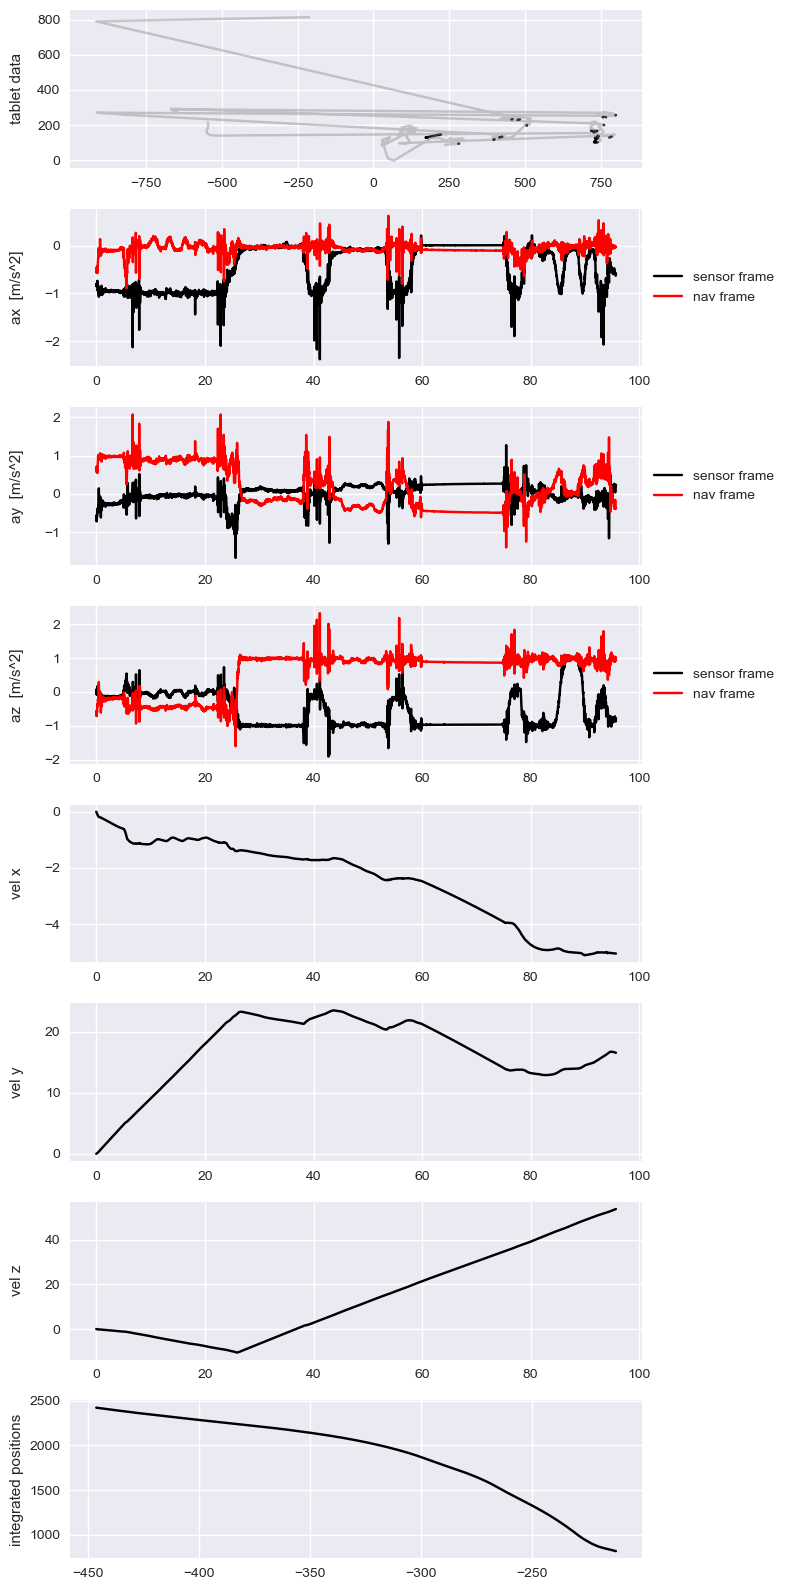

In [165]:
plot_segments(df)

-----------------------------------------------------------------------------------------------------------------

In [ ]:
from math import degrees
from math import atan2
from math import asin

def pyr(df):
    pitch = degrees( atan2(2 * df.q1 * df.q0 - 2 * df.q2 * df.q3, 1 - 2 * df.q1 * df.q1 - 2 * df.q3 * df.q3))
    yaw= degrees( atan2(2 * df.q2 * df.q0 - 2 * df.q1 * df.q3, 1 - 2 * df.q2 * df.q2 - 2 * df.q3 * df.q3))
    roll = degrees(asin(2 * df.q1 * df.q2 + 2 * df.q3 * df.q0))
    return pitch, yaw, roll